# Calculate density and velocity gradients

In [1]:
# Jupyter Notebook with widget matplotlib plots
#%matplotlib notebook
# Jupyter Lab with widget matplotlib plots
#%matplotlib widget 
# with Jupyter and Jupyter Lab but without widget matplotlib plots
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import sys
import pyicon as pyic
import cartopy
import seawater as sw

calc
tb
xarray
done xarray
IconData
plotting
view
calc
tb
IconData
plotting
view
quickplots
quickplots


In [3]:
ccrs_proj = cartopy.crs.PlateCarree()

## Specify data set

In [4]:
# # R2B6 data
# run = 'nib0004'
# runname = 'icon_08'
# gname = 'r2b6'
# lev = 'L64'
# t1 = '2100-02-01'
# # t2 = '2150-01-01'
# t2 = '2101-01-01'

# path_data     = f'/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/{runname}/icon-oes/experiments/{run}/'
# path_grid     = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{gname}/'
# path_ckdtree  = f'{path_grid}ckdtree/'
# fpath_ckdtree = f'{path_grid}ckdtree/rectgrids/{gname}_res0.30_180W-180E_90S-90N.npz'
# fpath_fx      = f'{path_grid}{gname}_{lev}_fx.nc'

# R2B4 data
run = 'nib0001'
runname = 'icon_15'
gname = 'r2b4_oce_r0003'
lev = 'L40'
t1 = '2023-01-01T00:00:00.000'
t2 = t1

path_data     = f'/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/{runname}/icon-oes/experiments/{run}/'
path_grid     = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{gname}/'
path_ckdtree  = f'{path_grid}ckdtree/'
fpath_ckdtree = f'{path_grid}ckdtree/rectgrids/{gname}_res0.30_180W-180E_90S-90N.npz'
fpath_fx      = f'{path_grid}{gname}_{lev}_fx.nc'

# # R2B8 data
# run = 'exp.ocean_era51h_r2b8_hel20218-ERA'
# runname = ''
# gname = 'r2b8_oce_r0004'
# lev = 'L128'
# t1 = '1979-12-01'
# t2 = '1979-12-01'

# path_data     = f'/work/mh0033/m211054/projects/icon/icon-oes-1.3.01/experiments/{run}/outdata/'
# path_grid     = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{gname}/'
# path_ckdtree  = f'{path_grid}ckdtree/'
# fpath_ckdtree = f'{path_grid}ckdtree/rectgrids/{gname}_res0.30_180W-180E_90S-90N.npz'
# fpath_fx      = f'{path_grid}{gname}_{lev}_fx.nc'

In [5]:
%%time
IcD = pyic.IconData(
    fname        = run+'_????????????????.nc',
    path_data    = path_data,
    path_grid    = path_grid,
    gname        = gname,
    lev          = lev,
    load_triangular_grid = True,
    do_triangulation    = False,
    omit_last_file      = False,
    calc_coeff          = True,
    calc_coeff_mappings = True,
              )

Start with calc_coeff...
Done with calc_coeff!
Start with calc_coeff_mappings...
--- fixed_vol_norm
--- edge2edge_viacell_coeff
--- edge2cell_coeff_cc
--- edge2cell_coeff_cc_t
Done with calc_coeff_mappings!
CPU times: user 1.26 s, sys: 162 ms, total: 1.42 s
Wall time: 1.46 s


In [6]:
IcD.grad_coeff = (1./IcD.dual_edge_length)

In [7]:
if run=='nib0001':
    extra_diag = True
else:
    extra_diag = False

In [8]:
if extra_diag:
    IcD_en = pyic.IconData(
        fname        = run+'_energy_????????????????.nc',
        path_data    = path_data,
        path_grid    = path_grid,
        gname        = gname,
        lev          = lev,
        do_triangulation    = True,
        omit_last_file      = False,
        calc_coeff          = True,
        calc_coeff_mappings = True,
                  )

Start with calc_coeff...
Done with calc_coeff!
Start with calc_coeff_mappings...
--- fixed_vol_norm
--- edge2edge_viacell_coeff
--- edge2cell_coeff_cc
--- edge2cell_coeff_cc_t
Done with calc_coeff_mappings!


Define time frame for averaging (shorter time periods should be chosen for testing):

## Derive gradients

Load time averaged data

In [9]:
# --- load data
uo, it_ave   = pyic.time_average(IcD, 'u', t1=t1, t2=t2, iz='all')
vo, it_ave   = pyic.time_average(IcD, 'v', t1=t1, t2=t2, iz='all')
# to, it_ave   = pyic.time_average(IcD, 'to', t1=t1, t2=t2, iz='all')
# so, it_ave   = pyic.time_average(IcD, 'so', t1=t1, t2=t2, iz='all')

In [10]:
zos, it_ave   = pyic.time_average(IcD, 'zos', t1=t1, t2=t2, iz='all')
rho_icon, it_ave = pyic.time_average(IcD, 'rho', t1=t1, t2=t2, iz='all')

In [11]:
if extra_diag:
    press_grad, it_ave = pyic.time_average(IcD_en, 'press_grad', t1=t1, t2=t2, iz='all')

## Geostrophic velocities

In [12]:
%%time
# potential density (should not be used)
rho_pot = sw.dens(so, to, 0.)
# in-situ density
rho_ins = sw.dens(so, to, IcD.depthc[:,np.newaxis])

NameError: name 'so' is not defined

In [13]:
# rho = rho_ins # (slightly more inaccurate)
# rho = rho_ins # (should not be used)
rho = rho_icon

Note pres $= p/\rho_0 = \phi$

In [14]:
# hydrostatic pressure without surface contribution
pres = np.zeros(rho.shape)
pres[0,:] = IcD.grav/IcD.rho0 * rho[0,:]*IcD.dzt[0,:]
pres[1:,:] = pres[0:1,:] + IcD.grav/IcD.rho0 * np.cumsum(0.5*(rho[1:,:]+rho[:-1,:])*IcD.dzt[1:-1,:], axis=0)

# --- simpler forms

# pressure at cell centre
# (with eos from seawater)
# pres = IcD.grav/IcD.rho0 * np.cumsum(rho_ins*IcD.dzt[:-1,:], axis=0)
# (with eos from ICON)
# pres = IcD.grav/IcD.rho0 * np.cumsum(rho*IcD.dzt[:-1,:], axis=0)
# at bottom of cell (should not be used)
# pres = IcD.grav/IcD.rho0 * np.cumsum(rho_ins*IcD.dzw, axis=0)

Contribution from surface elevation

In [15]:
psurf = np.tile(IcD.grav * zos[np.newaxis,:], [IcD.nz,1])
gradh_ps = (psurf[:,IcD.adjacent_cell_of_edge[:,1]]-psurf[:,IcD.adjacent_cell_of_edge[:,0]])*IcD.grad_coeff

Hydrostatic interior pressure gradient on cell edges

In [16]:
gradh_p = (pres[:,IcD.adjacent_cell_of_edge[:,1]]-pres[:,IcD.adjacent_cell_of_edge[:,0]])*IcD.grad_coeff
# add surface contibution
gradh_p += gradh_ps 

Interpolate to cell centre

In [17]:
%%time
p_gradh_p = pyic.edges2cell(IcD, gradh_p)
dpdx, dpdy = pyic.calc_2dlocal_from_3d(IcD, p_gradh_p)

CPU times: user 295 ms, sys: 60 ms, total: 355 ms
Wall time: 352 ms


Geostrophic velocities

In [18]:
ug = -1./(IcD.fc+1e-33) * dpdy
vg =  1./(IcD.fc+1e-33) * dpdx

Mask equator

In [19]:
ug[:,np.abs(IcD.clat)<5.] = np.ma.masked
vg[:,np.abs(IcD.clat)<5.] = np.ma.masked

Other estimate from where interior pressure is derived from ICON's interior pressure gradient

In [20]:
if extra_diag:
    pgrad = press_grad + gradh_ps
    p_gradh_p = pyic.edges2cell(IcD, pgrad)
    dpdx, dpdy = pyic.calc_2dlocal_from_3d(IcD, p_gradh_p)
    ug2 = -1./(IcD.fc+1e-33) * dpdy
    vg2 =  1./(IcD.fc+1e-33) * dpdx
    ug2[:,np.abs(IcD.clat)<5.] = np.ma.masked
    vg2[:,np.abs(IcD.clat)<5.] = np.ma.masked

## Profile plots

In [21]:
ic = np.argmin((IcD.clon+30)**2+(IcD.clat-26)**2)

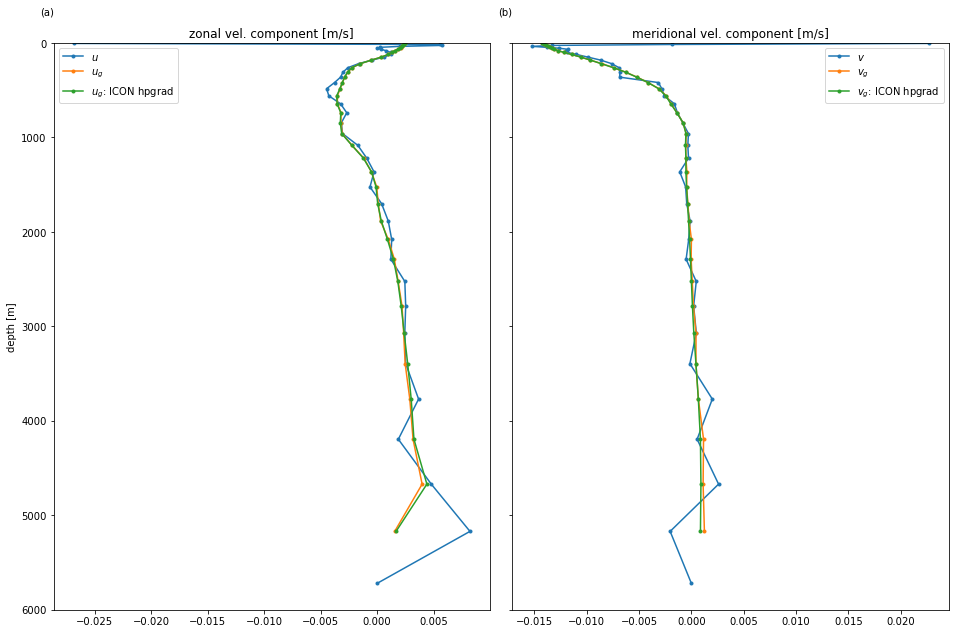

In [22]:
hca, hcb = pyic.arrange_axes(2,1, plot_cb=False, asp=1.3, fig_size_fac=5.,
                               sharex=False, sharey=True, ylabel="depth [m]",
                            )
ii=-1
pset = dict(marker='.')

ii+=1; ax=hca[ii]; cax=hcb[ii]
ax.plot(uo[:,ic], IcD.depthc, label='$u$', **pset)
ax.plot(ug[:,ic], IcD.depthc, label='$u_g$', **pset)
if extra_diag:
    ax.plot(ug2[:,ic], IcD.depthc, label='$u_g$: ICON hpgrad', **pset)
ax.legend()
ax.set_title('zonal vel. component [m/s]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
ax.plot(vo[:,ic], IcD.depthc, label='$v$', **pset)
ax.plot(vg[:,ic], IcD.depthc, label='$v_g$', **pset)
if extra_diag:
    ax.plot(vg2[:,ic], IcD.depthc, label='$v_g$: ICON hpgrad', **pset)
ax.legend()
ax.set_title('meridional vel. component [m/s]')

for ax in hca:
    ax.set_ylim(6000,0)

In [23]:
# hca, hcb = pyic.arrange_axes(2,1, plot_cb=False, asp=1.3, fig_size_fac=5.,
#                                sharex=False, sharey=True, ylabel="depth [m]",
#                             )
# ii=-1

# ii+=1; ax=hca[ii]; cax=hcb[ii]
# ax.plot(rho_pot[:,ic], IcD.depthc)
# ax.set_title('density')

# ii+=1; ax=hca[ii]; cax=hcb[ii]
# ax.plot(pres[:,ic], IcD.depthc)
# ax.set_title('pres')

# for ax in hca:
#     ax.set_ylim(6000,0)

## Horizontal plots

In [24]:
lon, lat, ugi = pyic.interp_to_rectgrid(ug, fpath_ckdtree, coordinates='clat clon')
lon, lat, vgi = pyic.interp_to_rectgrid(vg, fpath_ckdtree, coordinates='clat clon')
lon, lat, uoi = pyic.interp_to_rectgrid(uo, fpath_ckdtree, coordinates='clat clon')
lon, lat, voi = pyic.interp_to_rectgrid(vo, fpath_ckdtree, coordinates='clat clon')

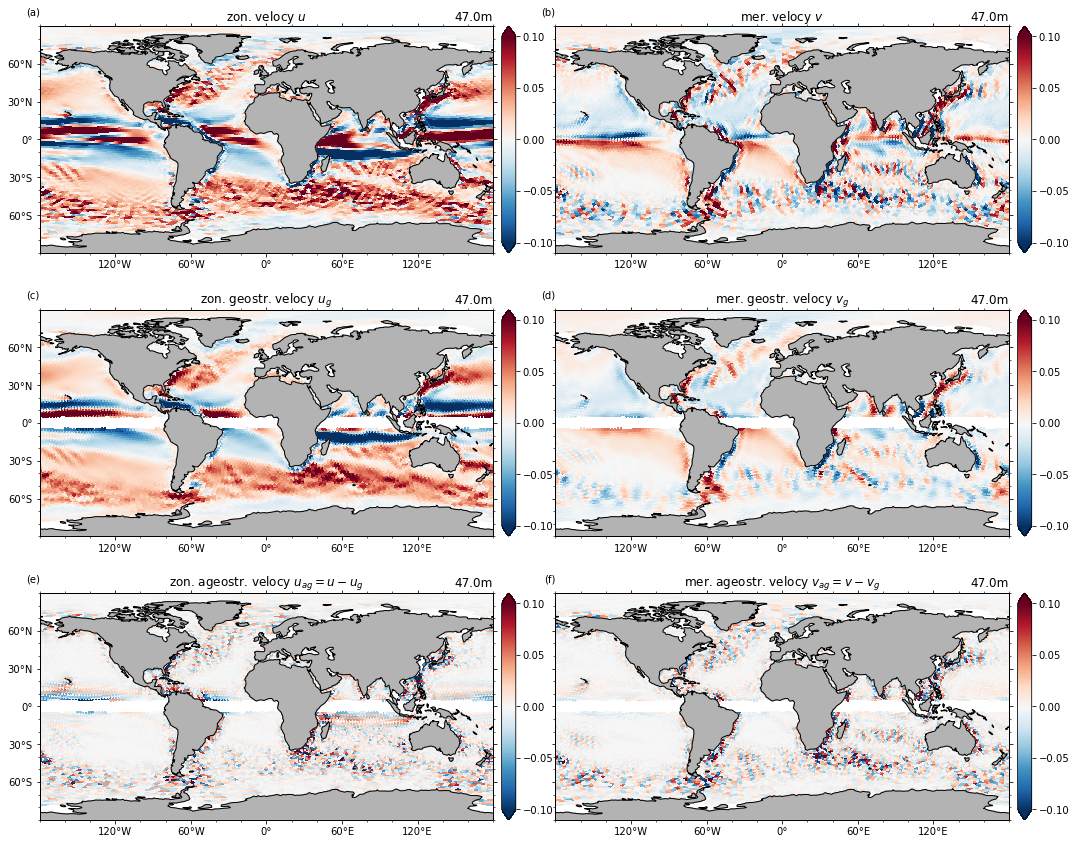

In [25]:
hca, hcb = pyic.arrange_axes(2,3, plot_cb=True, asp=0.5, fig_size_fac=2.,
                               sharex=False, sharey=True, xlabel="", ylabel="",
                               projection=ccrs_proj,
                            )
ii=-1

iz = np.argmin(np.abs(IcD.depthc-50.))
clim = 0.1

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, uoi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj, clim=clim)
ax.set_title('zon. velocy $u$')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, voi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj, clim=clim)
ax.set_title('mer. velocy $v$')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, ugi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj, clim=clim)
ax.set_title('zon. geostr. velocy $u_g$')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, vgi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj, clim=clim)
ax.set_title('mer. geostr. velocy $v_g$')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, (ugi-uoi)[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj, clim=clim)
ax.set_title('zon. ageostr. velocy $u_{ag} = u - u_g$')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, (vgi-voi)[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj, clim=clim)
ax.set_title('mer. ageostr. velocy $v_{ag} = v - v_g$')

for ax in hca:
    pyic.plot_settings(ax, template='global')
    ax.set_title(f'{IcD.depthc[iz]}m', loc='right')

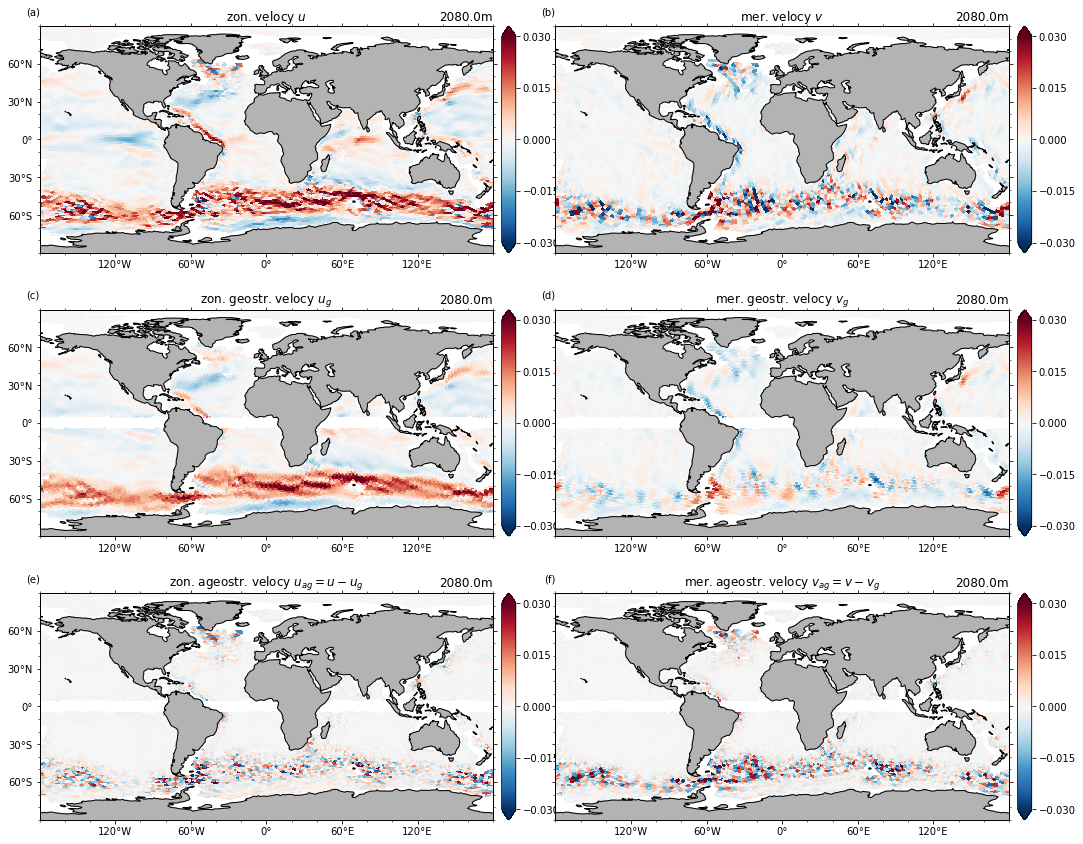

In [26]:
hca, hcb = pyic.arrange_axes(2,3, plot_cb=True, asp=0.5, fig_size_fac=2.,
                               sharex=False, sharey=True, xlabel="", ylabel="",
                               projection=ccrs_proj,
                            )
ii=-1

iz = np.argmin(np.abs(IcD.depthc-2000.))
clim = 0.03

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, uoi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj, clim=clim)
ax.set_title('zon. velocy $u$')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, voi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj, clim=clim)
ax.set_title('mer. velocy $v$')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, ugi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj, clim=clim)
ax.set_title('zon. geostr. velocy $u_g$')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, vgi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj, clim=clim)
ax.set_title('mer. geostr. velocy $v_g$')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, (ugi-uoi)[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj, clim=clim)
ax.set_title('zon. ageostr. velocy $u_{ag} = u - u_g$')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, (vgi-voi)[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj, clim=clim)
ax.set_title('mer. ageostr. velocy $v_{ag} = v - v_g$')

for ax in hca:
    pyic.plot_settings(ax, template='global')
    ax.set_title(f'{IcD.depthc[iz]}m', loc='right')